In [29]:
import os
import tensorflow as tf
from matplotlib import pyplot as plt

Data Preparation
- Download data
- Data pipeline

In [30]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [25]:
os.chdir('/content/sample_data/data') #get into previous directory
os.getcwd() #current directory

'/content/sample_data/data'

In [ ]:
!unzip archive_sampled.zip
#remove it, in case tf.keras.utils.image_dataset_from_directory make it third classes

In [37]:
tf.keras.utils.image_dataset_from_directory??

In [93]:
#Data from https://www.kaggle.com/datasets/iarunava/cell-images-for-detecting-malaria?resource=download
#Randomly pick 200 pics from both categories and upload the file.
#data/Uninfected and paratized
#image size 256,256
#batch 32
#label int
#data pipline
#shuffle=True
os.chdir('/content/sample_data')
data = tf.keras.utils.image_dataset_from_directory('data')

Found 400 files belonging to 3 classes.


In [94]:
data_iterator = data.as_numpy_iterator()
batch = data_iterator.next()
print(batch[1])
batch[0].shape
#Have no idea why the labels are 1 and 2

[2 1 2 1 1 2 2 2 2 2 1 1 2 1 2 2 2 2 2 2 2 1 1 1 1 2 2 2 2 1 2 2]


(32, 256, 256, 3)

In [95]:
# transfer y if y == 2 uninfected to 0
data = data.map(lambda x, y: (x, tf.where(tf.equal(y, 2), 0, y))) #map through data
data_iterator = data.as_numpy_iterator()
batch = data_iterator.next()
print(batch[1])

[0 1 1 0 1 0 1 1 0 0 1 1 0 0 0 0 1 0 1 1 0 0 0 1 0 0 0 1 1 0 1 1]


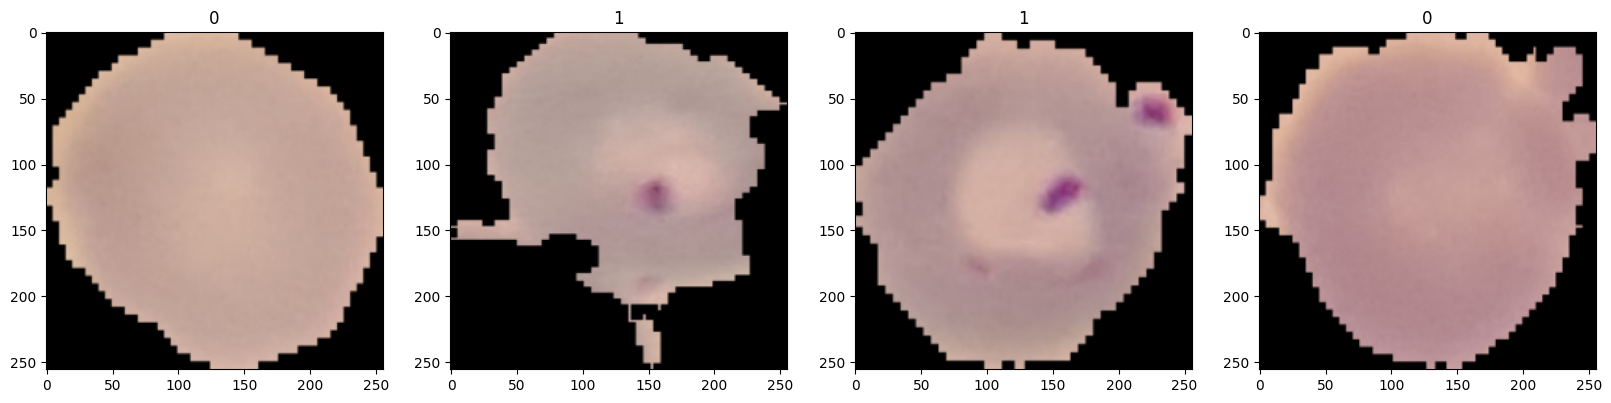

In [96]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][5:9]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [97]:
data = data.map(lambda x,y: (x/255, y)) #map through data

In [98]:
#training, validation, testing data splitting
train_size = int(len(data)*.8)
val_size = int(len(data)*.1)
test_size = int(len(data)*.1)

train = data.take(train_size) #take first 7 batches in a type of data
val = data.skip(train_size).take(val_size) #skip first 7 batches and take following 2
test = data.skip(train_size+val_size).take(test_size)

In [99]:
train_iterator = train.as_numpy_iterator()
batch_train = train_iterator.next()
batch_train[0].shape

(32, 256, 256, 3)

Building up model for an image classifier
- inherited from VGG16 using sequential symtax
- Check out feature extraction layer
- Hot spot image and anmoaly detection.

In [100]:
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Conv2D, MaxPooling2D , Flatten
from tensorflow.keras.applications import vgg16
from tensorflow.keras.optimizers import Adam, SGD
import scipy  #Used to upsample our image

import os
import cv2
from PIL import Image
import numpy as np

In [207]:
input_shape = (256,256,3)

#remove flatten and NN and keep the CNN layers (include_top=False)
#CNN layers learned from imagenet.
tf.keras.backend.clear_session()

vgg = vgg16.VGG16(weights='imagenet', include_top=False, input_shape = input_shape)
for layer in vgg.layers[:]:
  print(layer.name)
for layer in vgg.layers[:-5]:
  layer.trainable = False #All others as non-trainable. transfer learning.

x = vgg.output
x = GlobalAveragePooling2D()(x) #Use GlobalAveragePooling and NOT flatten.
x = Dense(16, activation='relu')(x)
x = Dense(1, activation="sigmoid")(x)  #binary classfier
model = Model(vgg.input, x)
model.summary()

input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_pool
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                      

In [208]:
model.compile(loss = tf.losses.BinaryCrossentropy(),
                  optimizer = 'Adam', metrics=["accuracy"])

Epoch 1/20
10/10 [==============================] - 5s 266ms/step - loss: 0.8911 - accuracy: 0.4969 - val_loss: 0.6974 - val_accuracy: 0.4375
Epoch 2/20
10/10 [==============================] - 3s 244ms/step - loss: 0.6989 - accuracy: 0.5250 - val_loss: 0.6935 - val_accuracy: 0.5312
Epoch 3/20
10/10 [==============================] - 3s 270ms/step - loss: 0.6981 - accuracy: 0.5469 - val_loss: 0.6798 - val_accuracy: 0.5312
Epoch 4/20
10/10 [==============================] - 3s 239ms/step - loss: 0.6839 - accuracy: 0.5688 - val_loss: 0.6876 - val_accuracy: 0.5000
Epoch 5/20
10/10 [==============================] - 3s 247ms/step - loss: 0.5711 - accuracy: 0.7125 - val_loss: 0.4369 - val_accuracy: 0.7812
Epoch 6/20
10/10 [==============================] - 3s 317ms/step - loss: 0.5158 - accuracy: 0.7531 - val_loss: 0.6000 - val_accuracy: 0.6250
Epoch 7/20
10/10 [==============================] - 3s 249ms/step - loss: 0.5429 - accuracy: 0.7250 - val_loss: 0.4998 - val_accuracy: 0.7188
Epoch 

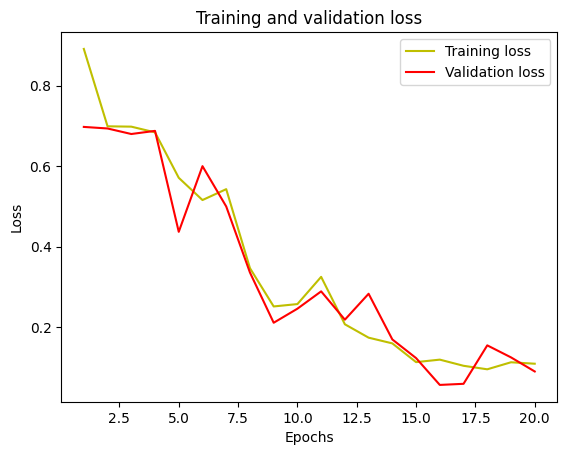

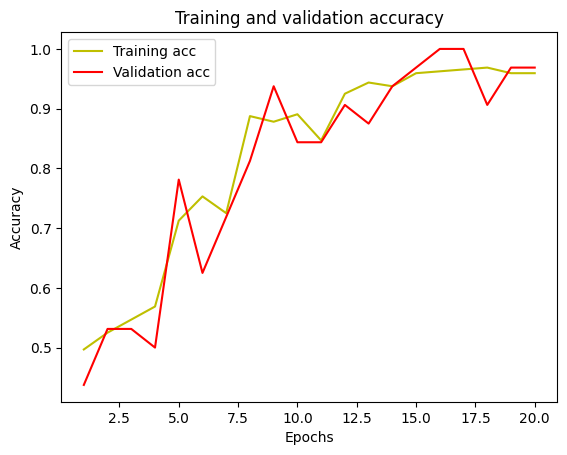

In [209]:
history = model.fit(train, epochs=20, verbose = 1, validation_data=val)

#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Check Out what do CNN layers see?

In [120]:
#first CNN layers
CNN_layers = model.layers[:3]
CNN_model = Sequential(CNN_layers)
CNN_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
Total params: 38,720
Trainable params: 0
Non-trainable params: 38,720
_________________________________________________________________


In [121]:
#Get data from test
test_iterator = test.as_numpy_iterator()
batch_test = test_iterator.next()
print(batch_test[1][0])
batch_test[0][0].shape

1


(256, 256, 3)

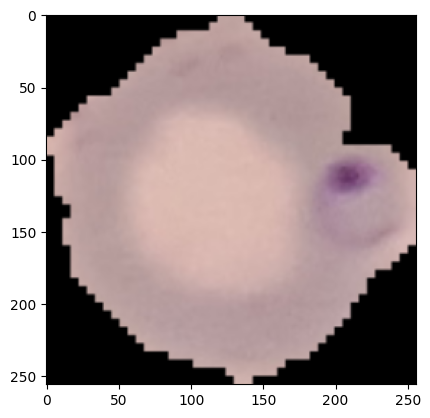

In [128]:
plt.imshow(batch_test[0][0]) #label 1, it's infected

In [108]:
CNN_model.input_shape

(None, 256, 256, 3)

In [122]:
yhat = CNN_model.predict(np.expand_dims(batch_test[0][0],0))

1/1 [==============================] - 0s 160ms/step


In [123]:
yhat.shape #shape of last layer

(1, 256, 256, 64)

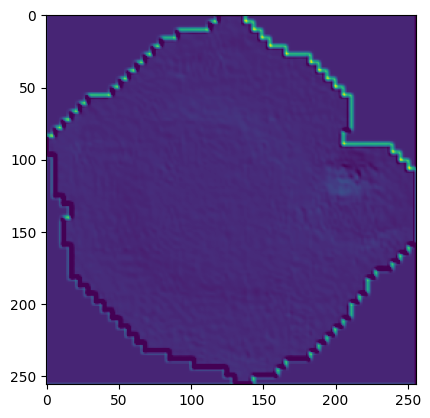

In [126]:
plt.imshow(yhat[0,:,:,5])

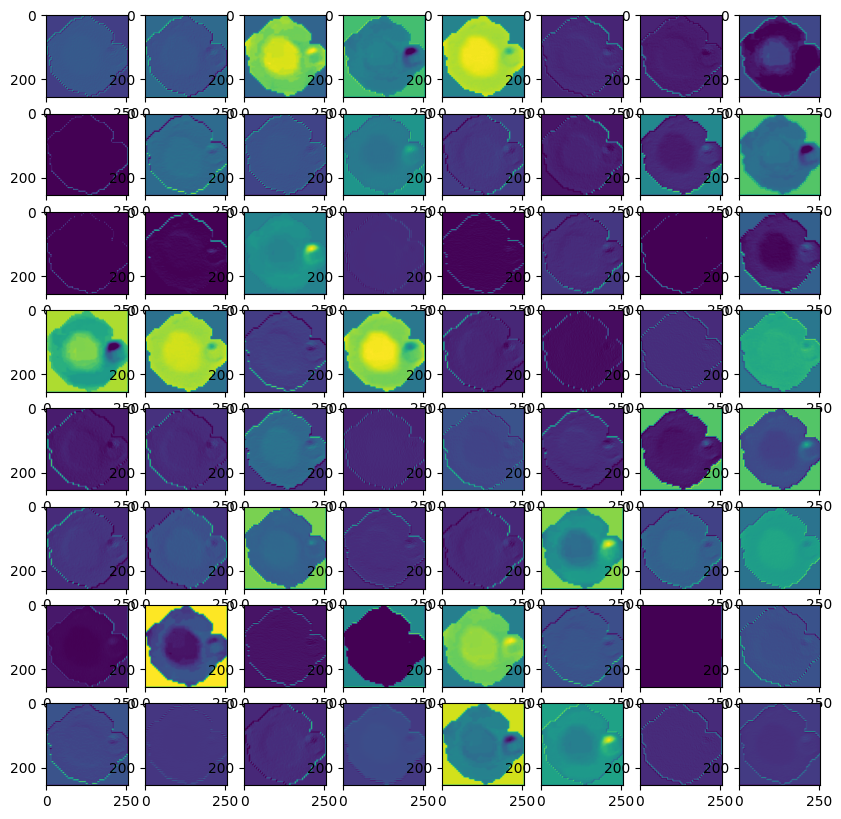

In [129]:
# Viz Grid
import itertools

num_rows = 8
num_cols = 8

fig, ax = plt.subplots(ncols=num_cols, nrows=num_rows, figsize=(10,10))
for idx, ax_idx in enumerate(list(itertools.product(range(num_rows), range(num_cols)))):
    ax[ax_idx[0], ax_idx[1]].imshow(yhat[0,:,:,idx])

In [131]:
# 2nd CNN layers
CNN_layers = model.layers[:7]
CNN_model = Sequential(CNN_layers)
CNN_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0         
                                                                 
Total params: 260,160
Trainable params: 0
Non-trainabl

1/1 [==============================] - 0s 18ms/step


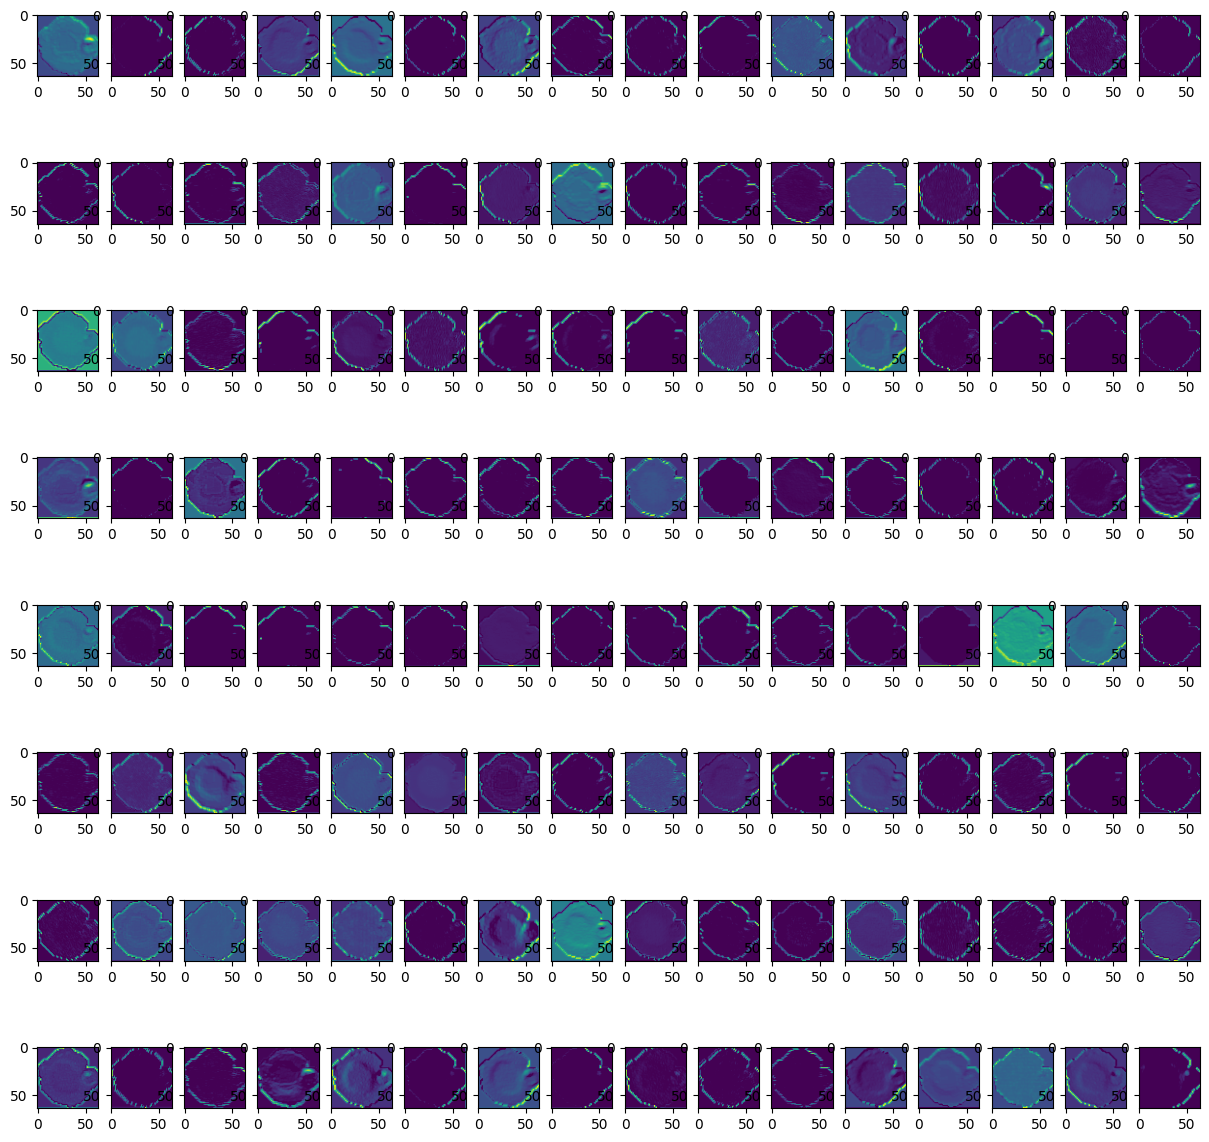

In [133]:
yhat = CNN_model.predict(np.expand_dims(batch_test[0][0],0))

num_rows = 8
num_cols = 16

fig, ax = plt.subplots(ncols=num_cols, nrows=num_rows, figsize=(15,15))
for idx, ax_idx in enumerate(list(itertools.product(range(num_rows), range(num_cols)))):
    ax[ax_idx[0], ax_idx[1]].imshow(yhat[0,:,:,idx])


In [155]:
# last CNN layers
CNN_layers = model.layers[:-4]
CNN_model = Sequential(CNN_layers)
CNN_model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 64, 64, 256)     

1/1 [==============================] - 0s 350ms/step


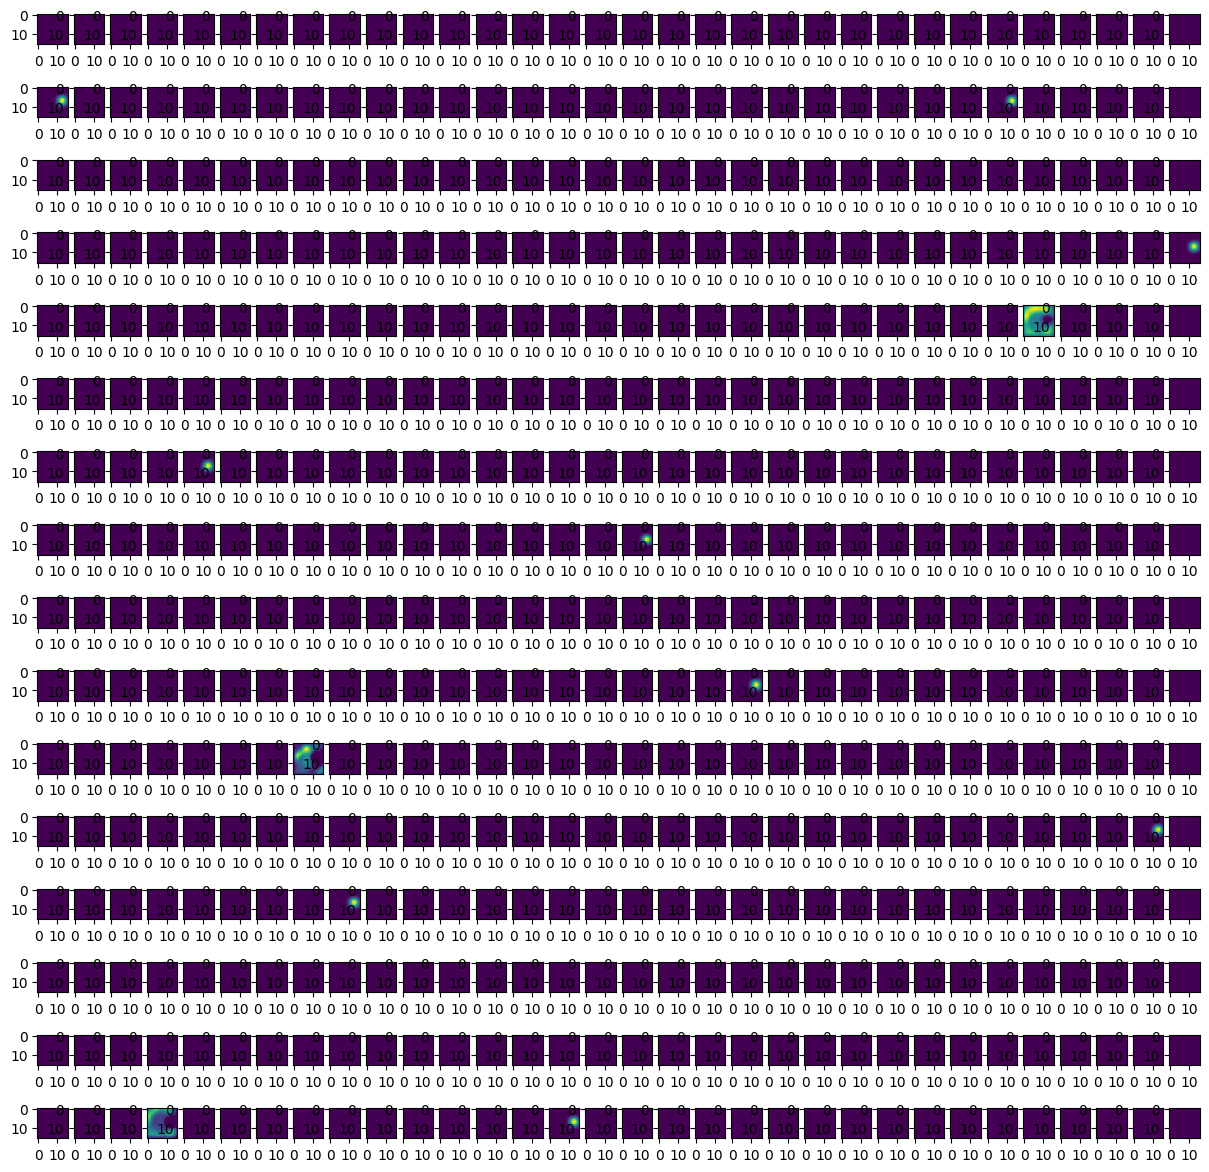

In [156]:
yhat_last_CNNlayer = CNN_model.predict(np.expand_dims(batch_test[0][0],0))

num_rows = 16
num_cols = 32

fig, ax = plt.subplots(ncols=num_cols, nrows=num_rows, figsize=(15,15))
for idx, ax_idx in enumerate(list(itertools.product(range(num_rows), range(num_cols)))):
    ax[ax_idx[0], ax_idx[1]].imshow(yhat_last_CNNlayer[0,:,:,idx])


# A lot of redundant kernels

In [154]:
# GlobalAveragePooling layers
CNN_layers = model.layers[:-2]
CNN_model = Sequential(CNN_layers)
#Model(model.input, model.get_layer("block5_conv3").output)
CNN_model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 64, 64, 256)     

In [148]:
#GlobalAveragePooling collaspe the output of last CNN layer with size 1,8,8,512 to 1,512
#It decide which kernels are really doing their job rather than filtering nothing.
yhat_GAP = CNN_model.predict(np.expand_dims(batch_test[0][0],0))
yhat_GAP

1/1 [==============================] - 0s 143ms/step


array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        , 36.573963  ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        , 22.0135    ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0. 

In [210]:
# prediction layer from original model, go back and execute it again
# In the showcase, he use softmax and treat it as mutiple classifer with 2 classes. unlike binary classifer

model.layers[-1].get_weights()[0]

array([[ 0.04301405],
       [ 0.4763338 ],
       [-0.57256925],
       [ 0.3295527 ],
       [ 0.15838294],
       [ 0.51845425],
       [ 0.2718135 ],
       [ 0.2750972 ],
       [ 0.43585557],
       [ 0.3034315 ],
       [ 0.2170775 ],
       [ 0.44171876],
       [-0.20841809],
       [ 0.38816756],
       [-0.4148529 ],
       [ 0.1022789 ]], dtype=float32)

In [160]:
print(yhat_last_CNNlayer.shape)
print(yhat_GAP.shape)

(1, 16, 16, 512)
(1, 512)


In [157]:
np.squeeze(yhat_last_CNNlayer).shape

(16, 16, 512)

Anomaly Detaction

In [159]:
#Resize the output from last CNN layer ori: 8x8x512
import scipy  #Used to upsample our image

h = int(256/16) #256/16 size of original image / size of CNN output
w = int(256/16)
upsampled_last_conv_output = scipy.ndimage.zoom(np.squeeze(yhat_last_CNNlayer), (h, w, 1), order=1)
upsampled_last_conv_output.shape

(256, 256, 512)

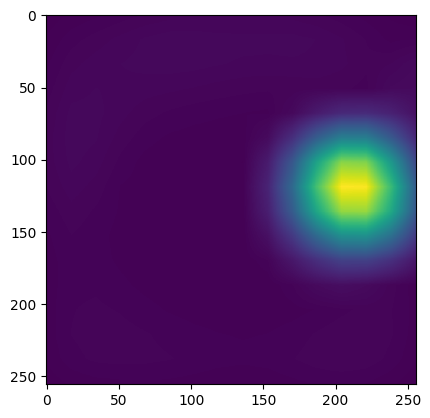

In [220]:
#CNN out put with size (256,256,512) -> (256*256,512)
#activate kernels by mutiply CNN out put (256*256,512) by GAP output (1,512). This pattern or kernel play contribute how much to the task
#average them kernel-wise and come up with a 256,256 filter that represent the overall effect of CNN layer.

heat_map = np.mean((upsampled_last_conv_output.reshape(256*256, 512) * yhat_GAP).reshape(256,256,512), axis=2)
plt.imshow(heat_map)

In [222]:
img = batch_test[0][0]
img.shape

(256, 256, 3)

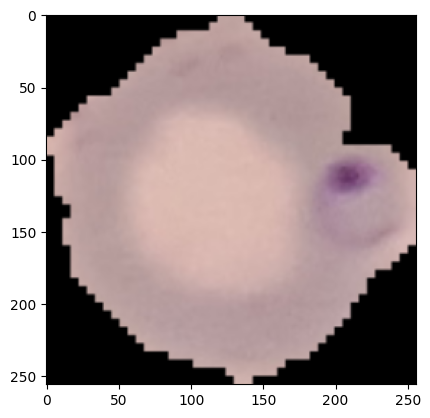

In [226]:
plt.imshow(img)

0


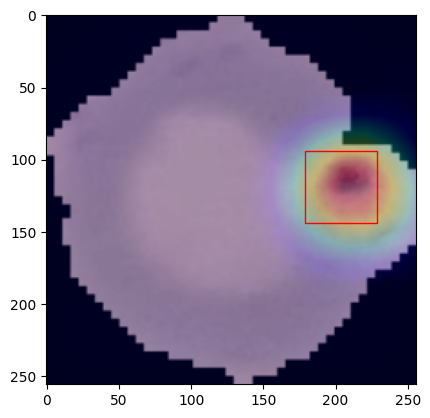

In [231]:
from matplotlib.patches import Rectangle #To add a rectangle overlay to the image
from skimage.feature.peak import peak_local_max  #To detect hotspots in 2D images.
img = batch_test[0][0]

peak_coords = peak_local_max(heat_map, num_peaks=5, threshold_rel=0.5, min_distance=10)

plt.imshow(img)
plt.imshow(heat_map, cmap='jet', alpha=0.25)

for i in range(0,peak_coords.shape[0]):
  print(i)
  y = peak_coords[i,0]
  x = peak_coords[i,1]
  plt.gca().add_patch(Rectangle((x-25, y-25), 50,50,linewidth=1,edgecolor='r',facecolor='none'))